In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-taxi-trip-data-google-public-data/original_cleaned_nyc_taxi_data_2018.csv
/kaggle/input/nyc-taxi-trip-data-google-public-data/taxi_trip_data.csv
/kaggle/input/nyc-taxi-trip-data-google-public-data/taxi_zone_geo.csv


In [26]:
df = pd.read_csv('/kaggle/input/nyc-taxi-trip-data-google-public-data/taxi_trip_data.csv')
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
0,2,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1
1,2,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230
2,2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231
3,2,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138
4,2,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138


# Intro  

The goal of this notebook is to clean and analize the data available for the purpose of later utilizing it in machine learning algorithms to generate predictions of fare amounts for potential rides and riders.  

The most important step here, is to define clearly what will be predicted, and then explore what will and might be required to run that prediction. Once these values have been defined, the data cleaning process can begin to clear out outliers, missing values and other noise which might effect the results of the algorithm.  

## ML Goal  

At first, it might seem obvious that the machine learning algorithm should be predicting the fare amount outright, but this can actually be accomplished without any machine learning at all. In fact, it's entirely possible to predict the total amount without machine learning as well! It would take a tremendous effort, but that's not to say it can't be done. So what is the ML model actually doing?  
The point of the model is to make these predictions as easy as possible. Rather than looking up routes, tolls, fees, the time of the day and all other variables ourselves, we want to just plug in specific variables and generate an output that is as close as possible to what the actual fare turns out to be.  
The fare amount portion is easy. According to the NYC government taxi fares website, a taxi fare is calculated as an initial \\$2.50 pickup fee, 50 cents per mile when moving above 12mph, and 50 cents per minute when travelling beloww 12mph, plus 50 cents MTA State Surcharge for all trips that end in New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties, a 30 cent improvement surcharge, 50 cents for overnight (8pm to 6am) and a \$1.00 charge for rushhour, between 4pm and 8pm on weekdays. The site also mentions a variable fee for certain trips ending in or passing through Manhattan, south of 96th street, but as we'll see shortly, our data doesn't accout for this. This may be a newer rule since 2019, or for some reason it wasn't included in the original data collection.  
This isn't a difficult calculation to run, but it just gives us the fare amount after the trip has completed, and that's not what we're after. We want to know what the fare amount will be before the trip! This means that more features are going to matter here. An important note to keep in mind, is that the website also mentions that the number of riders does not effect the fare amount in any way, so essentially, we can ignore this data immediately. Though it might be interesting, it's of no use to the model.   

The first, and probably most obvious thing, is determining where the pickup and dropoff locations are. Rides following the similar path in the past will likely take similar routes, and rides during the same hours of the day will also likely take roughly the same amount of time. This gives us a sort of rolling average for distance and time to make the calculation easier, what it doesn't give us, is how much of that distance is sitting in traffic, below 12mph, or driving at normal speeds above 12mph, nor does it account for sitting at red lights.  
These values are hard to account for. While patterns can be detected when analysing the data through graphs and other visuals, it doesn't make for a very mathematical or repeatable prediction. We'll need the model to detect these patterns quickly and repeatably to get the most accurate predictions possible, which means some data, such as start and end times should be broken down into chunks that are easier for a machine to read such as the number of minutes per trip, the month, day, day of the week, and year (separately) . In a larger dataset containing more than just 2019, this could also allow the model to detect patterns in the time of year and the time of the month. In this project, we'll only be able to calculate patterns in the month, such as trips taking longer during december due to higher traffic, or the day of the week, like weekdays being busier due to being during normal working schedules.   

## Planning for Features  

Here are the features of the current dataset that we'll keep, as well as a few that will need to be created based on other features, this is called feature engineering:  
- pickup_timestamp  
- dropoff_timestamp  
- trip_distance  
- fare_amount  
- extra  
- mta_tax  
- imp_surcharge  
- total_amount  
- pickup_location_id  
- dropoff_location_id  

While it should be self explanatory so far why I chose to keep these variables, some might wonder "why not tip amount?". 
Well, tip amount is only included in the total amount, and is what I like to call "wild". Riders can pay whatever they want in tips, and these tips are only tips paid via credit cards, not in cash. This means that there will be no correlation between the tip amount and total amount, other than adding it to the fare. Tips shouldn't play a role in predicting a fare because they're entirely voluntary and contain no real patterns.  

Then there is also values such as "rate_code", which is defined by the collector as the rate code in effect at the end of the trip, and then lists specific locations, which happen to be mentioned above in the bit about certain charges for certain areas. It's very possible that this value is necessary for an accurate prediction, but we're going to need to explore further to determine if this is true or not. This holds true for all of the other remaining datapoints, so let's get on with the initial exploration.  



## Exploration  

One of the most powerful tools I have found for quickly calculating and visualizing the correlation between different values is a correlation matrix or heatmap.  
The correlation matrix calculates how the change in one value effects a change in the other value, and assigns a value between -1 and 1 to that correlation.  
Let's review what those correlation values mean before we move on:  

-1 A very strong negative correlation, when value A moves in one direction, value B moves in the opposite direction.  
0  No correlation between values A and B, when one moves, the other is not effected.  
1  A very strong positive correlation, as you can guess, this is the opposite of the negative correlation above. When value A moves in one direction, value B follows in the same direction.  

It's important to remember that this value isn't related to the rate of change, only the direction of change. Value A moves up, and value B either stays, moves up, or moves down.  

Let's generate that matrix and plot it out in a heatmap!  

In [27]:
# Generating the correlation matrix
corr = df.corr()

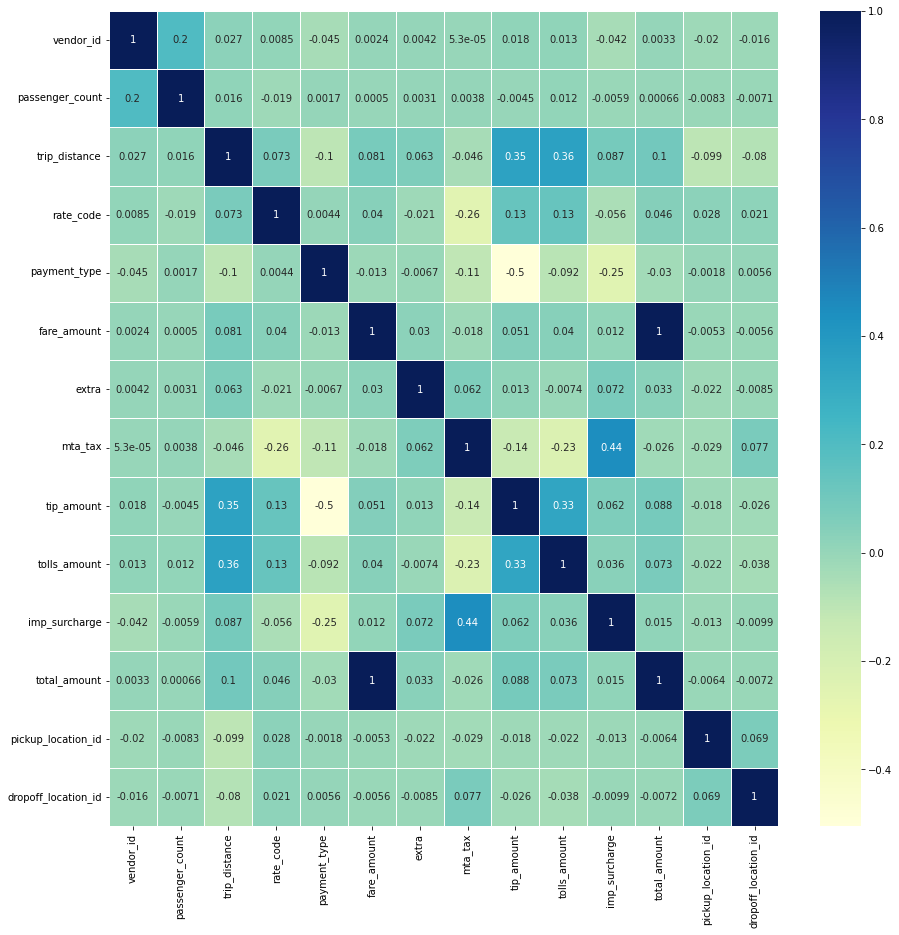

In [28]:
# Drawing the heatmap
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, cmap='YlGnBu', annot=True, linewidths=0.5);

So let's first list the values we should be focusing on here, we already have a list of known values that we should keeep, the only remaining values are:  
- vendor_id - Vendor of data provider. This definitely won't be used for anything for our model here  
- rate_code - The rate code at the end of the trip. Used likely to track certain charges. Has a correlation with tolls and tips but not much with anything else.  
- sotre_and_fwd_flag - This is simply a fag that indicates whether a value was stored in vehicle memory before being recorded due to a lack of internet connection. This is useless to us, however, it's currently stored as a string and converting it to a value that can appear in a correlation matrix later might serve useful. While not likely, it could be possible that values are different from those not stored in memory, such as having a higher amount of errors, or some upload process might be altering values in an unexpected way. I'll keep this for now and check for any correlations later.  

Okay, so in the end, we're only dropping one column right off the start and that's vendor ID. We have a lot of data to work with so any small amount of change will make a larger than usual impact, so I'll drop that now and then talk about the next steps.

In [29]:
# df = df.drop('vendor_id', axis=1)
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id
0,2,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,0.0,16.16,10.50,0.3,96.96,161,1
1,2,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,0.5,5.16,0.00,0.3,30.96,13,230
2,2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,0.5,0.76,0.00,0.3,4.56,231,231
3,2,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,0.5,5.61,5.76,0.3,61.67,231,138
4,2,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,0.5,10.41,5.76,0.3,62.47,87,138


## Cleaning  

Now to the fun stuff!  
It's tempting to get right into feature engineering and analysis at this point, but analyzing a "dirty" dataset wastes lots of time creating an analysis that may turn out to be very different once issues have been resolved, and engineering new features may cause headaches due to errors such as mathematical functions that don't work (imagine dividing by zero!) or missing data.  

Let's review the cleaning steps that need to be completed before we start: (Pandas actually does a lot for us just by loading data into a dataframe)  
1. Remove duplicate rows - Carefully, as we only want to remove duplicate trips, not duplicates within the values themselves. These values are not required to be unique.
2. Check for missing values  
3. Check for zeros and empty strings. These values won't be "missing" but still aren't valid. Very few columns in this data have valid zeros  
4. Validate formatting of data, especially dates  
5. Strip and normalize strings - our data doesn't contain any strings, so we can skip this.  

In [30]:
# Remove duplicates - Easy first step for reducing the size of the data, making following steps quicker  
# From here on, I'm going to rename the dataframe from df to td for temporary data, thus not altering the original dataframe until much later. 
td = df.drop_duplicates()
# less than 1% dropped
print(f"{df.shape[0] - td.shape[0]} duplicate rows dropped. Thats {df.shape[0] / td.shape[0] * 100}%")
print(f"{td.shape[0]} rows remain.")

607571 duplicate rows dropped. Thats 106.46873135799058%
9392429 rows remain.


In [31]:
# Checking for missing values
for col in td.columns:
    missing = td[col].isna().sum()
    print(f"Missing values in {col}: {missing}")

Missing values in vendor_id: 0
Missing values in pickup_datetime: 0
Missing values in dropoff_datetime: 0
Missing values in passenger_count: 0
Missing values in trip_distance: 0
Missing values in rate_code: 0
Missing values in store_and_fwd_flag: 0
Missing values in payment_type: 0
Missing values in fare_amount: 0
Missing values in extra: 0
Missing values in mta_tax: 0
Missing values in tip_amount: 0
Missing values in tolls_amount: 0
Missing values in imp_surcharge: 0
Missing values in total_amount: 0
Missing values in pickup_location_id: 0
Missing values in dropoff_location_id: 0


In [32]:
# Checking for zeros in numeric columns
def check_for_zeros(td):
    for col in td.columns:
        zeros = td[td[col] == 0].shape[0]
        print(f"Zeros in {col}:{zeros}")
        
check_for_zeros(td)

Zeros in vendor_id:0
Zeros in pickup_datetime:0
Zeros in dropoff_datetime:0
Zeros in passenger_count:85779
Zeros in trip_distance:264896
Zeros in rate_code:0
Zeros in store_and_fwd_flag:0
Zeros in payment_type:0
Zeros in fare_amount:12176
Zeros in extra:5048008
Zeros in mta_tax:285657
Zeros in tip_amount:2062555
Zeros in tolls_amount:6253748
Zeros in imp_surcharge:12433
Zeros in total_amount:5725
Zeros in pickup_location_id:0
Zeros in dropoff_location_id:0


Okay, first issue.   
passenger_count, trip_distance, far_amount and total_amount all contain zeros. It doesn't appear to be a large amount of the overal data. I'd normally check what the percentage of the entire dataset these values account for, however, passenger_count has already been determined to not be kept and the rest of the information can't really be filled in with any mathematical methods because each of the values depends on the other to be calculated. Without distance, we can't determine fare amount, even with distance, it's impossible to know which miles were driven above the 12mph threshold and which were below. There isn't much of a choice but to drop these, however, total_amount can be corrected by simply adding all of the charge column values together, so I'll keep and fix these rows.

In [33]:
# Dropping rows with 0 values in columns where 0 is not allowed
# td = td.drop(['passenger_count'], axis=1)
td = td[td['trip_distance'] > 0]
td = td[td['fare_amount'] > 0]

check_for_zeros(td)

Zeros in vendor_id:0
Zeros in pickup_datetime:0
Zeros in dropoff_datetime:0
Zeros in passenger_count:80430
Zeros in trip_distance:0
Zeros in rate_code:0
Zeros in store_and_fwd_flag:0
Zeros in payment_type:0
Zeros in fare_amount:0
Zeros in extra:4836000
Zeros in mta_tax:216469
Zeros in tip_amount:1886004
Zeros in tolls_amount:5980138
Zeros in imp_surcharge:1418
Zeros in total_amount:0
Zeros in pickup_location_id:0
Zeros in dropoff_location_id:0


After dropping rows with zero values in other columns, there remains no zeros in total_amount, so no corrections necessary!

In [34]:
# Checking how much of the original data ramains
remaining = td.shape[0] / df.shape[0] * 100
print(f"Remaining amount of original dataset: {remaining}%")

Remaining amount of original dataset: 90.99450999999999%


Now it's time to handle the data formatting.  
Pandas does a lot of this for us by assigning dtyps to each column. We would receive a DtypeWarning if multiple types existed in the same column.  
All that's really left to do is ensure that the dates are all readable date formats and exist in the same format such as mm/dd/yyyy, for example. 

In [35]:
# Converting to an actual Python/Pandas datetime object ensures that the data is a valid datetime. Then we can move on to exploring the datetimes available.
td['pickup_datetime'] = pd.to_datetime(td['pickup_datetime'])
td['dropoff_datetime'] = pd.to_datetime(td['dropoff_datetime'])

print('Done.')

Done.


Before we get onto exploring the dates, it will make things easier to split the datetime up into meaninful columns. We'll also need these values for our model, as mentioned above, so now's a good time to go ahead and do that!  

The only dropoff information we really need to keep is the hour, and even then, only to calculate the length of the trip. Therefore, I think it makes more sense to go ahead and calculate that value now. We'll save it as seconds.  

In [36]:
td['year'] = pd.to_datetime(td['pickup_datetime']).dt.year
td['month'] = pd.to_datetime(td['pickup_datetime']).dt.month
td['day'] = pd.to_datetime(td['pickup_datetime']).dt.day
td['day_of_week'] = pd.to_datetime(td['pickup_datetime']).dt.dayofweek
td['hour_of_day'] = pd.to_datetime(td['pickup_datetime']).dt.hour

print('Done')

Done


**Creating the Trip Duration**

_p.s. After learning how NumPy could replace df.apply(), this has become my favorite code that I've ever written. NumPy is AWESOME!_

In [37]:
# Converting the datetime columns to a numpy array for vectorization
pickup_array = td['pickup_datetime'].values
dropoff_array = td['dropoff_datetime'].values

# Getting the new timedelta, this takes less than a second to complete compared to 15+ minutes with apply()
trip_duration = np.subtract(dropoff_array, pickup_array)

# Adding the resulting array to the dataframe in the trip_duration column
td['trip_duration'] = pd.Series(trip_duration)

# Converting the timedelta to number of seconds
td['trip_duration'] = td['trip_duration'].dt.total_seconds()

# Preview the results
td.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,...,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
0,2,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,...,0.3,96.96,161,1,2018,3,29,3,13,2388.0
1,2,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,...,0.3,30.96,13,230,2018,3,29,3,13,2295.0
2,2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,...,0.3,4.56,231,231,2018,3,29,3,13,66.0
3,2,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,...,0.3,61.67,231,138,2018,3,29,3,13,3317.0
4,2,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,...,0.3,62.47,87,138,2018,3,29,3,14,3648.0


Now, the datetime columns can be dropped entirely!  

Let's do this before moving onto anything else, we're on a roll here with the dates anyways

In [38]:
# td.drop(['pickup_datetime', 'dropoff_datetime'], axis=1, inplace=True)

In [39]:
td.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,...,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
0,2,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,...,0.3,96.96,161,1,2018,3,29,3,13,2388.0
1,2,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,...,0.3,30.96,13,230,2018,3,29,3,13,2295.0
2,2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,...,0.3,4.56,231,231,2018,3,29,3,13,66.0
3,2,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,...,0.3,61.67,231,138,2018,3,29,3,13,3317.0
4,2,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,...,0.3,62.47,87,138,2018,3,29,3,14,3648.0


Now that the dates have been broken down properly, and we have our trip duration sorted out, we can move on to bigger and better things, more cleaning!  
First up, any trips with a duration of 0 need to be dropped. These trips won't be useful, and are certaintly caused by a data entry error.  
Second, we can investigate what years are available in this dataset, how much of the dataset each year makes up, and begin investigating whether we should keep all years, or only specific years by visualizing trends in fare amounts when compared to trip duration and distance.  

In [40]:
td = td[td['trip_duration'] > 0]

In [41]:
list_of_years = td.year.unique()
print(list_of_years)

[2018 2009 2017 2019 2008 2020 2003 2002 2001 2029 2032]


In [42]:
for year in list_of_years:
    year_amount = td[td['year'] == year].shape[0]
    total_amount = td.shape[0]
    
    print(f"{year} makes up {(year_amount / total_amount) * 100}% of the dataset")

2018 makes up 99.99841696039846% of the dataset
2009 makes up 0.0006356143854646263% of the dataset
2017 makes up 0.00020387631231884242% of the dataset
2019 makes up 0.00014391269104859462% of the dataset
2008 makes up 0.0004917016944160317% of the dataset
2020 makes up 1.1992724254049552e-05% of the dataset
2003 makes up 2.3985448508099104e-05% of the dataset
2002 makes up 2.3985448508099104e-05% of the dataset
2001 makes up 2.3985448508099104e-05% of the dataset
2029 makes up 1.1992724254049552e-05% of the dataset
2032 makes up 1.1992724254049552e-05% of the dataset


## Unexpected Results  

It's clear that this dataset is VERY HEAVILY weighted towards 2018. For that reason, dropping anything from before 2018 can help avoid skewing the data towards old trends, while keeping anything newer than 2018 might reveal new trends, although, I don't think it will be super useful. If a dataset of this size consists of 99% of the same year, it's likely that the trips from newer years are either invalid data upon collection, and incomplete enough to actually show any trends.  

While this is sort of a bummer, as I'd like to see newer data, it makes the decision super easy. Keep 2018, drop the rest. We'll lose less than 0.01% of the total dataset, and avoid any skews based on potentially invalid data in other columns of those years.  

After dropping these rows, I'll start checking the last few bits of our data here, starting with the total_amount. This value should be equal to the sum of the fare_amount, mta_tax, tip_amount, tolls_amount, imp_surcharge and the extra.

In [43]:
td = td[td['year'] == 2018]

td.describe()

,vendor_id,passenger_count,trip_distance,rate_code,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration
count,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8338257.0,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06,8.338257e+06
mean,1.616336e+00,1.609529e+00,9.120187e+00,1.154223e+00,1.180907e+00,3.178215e+01,3.469645e-01,4.882261e-01,5.526390e+00,2.174295e+00,2.999538e-01,4.062672e+01,1.528662e+02,1.476428e+02,2018.0,6.459984e+00,1.576347e+01,2.950375e+00,1.380998e+01,2.210049e+03
std,5.151929e-01,1.251360e+00,5.879868e+00,6.330880e-01,4.073165e-01,7.560952e+01,5.659283e-01,8.265593e-02,4.568232e+00,3.748963e+00,3.744167e-03,7.668925e+01,6.017347e+01,7.560037e+01,0.0,3.423810e+00,8.640502e+00,1.930177e+00,6.231820e+00,4.865978e+03
min,1.000000e+00,0.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e-02,-8.000000e+01,0.000000e+00,0.000000e+00,-5.760000e+00,0.000000e+00,3.100000e-01,1.000000e+00,1.000000e+00,2018.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,6.030000e+00,1.000000e+00,1.000000e+00,2.350000e+01,0.000000e+00,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,2.915000e+01,1.320000e+02,8.800000e+01,2018.0,3.000000e+00,9.000000e+00,1.000000e+00,1.000000e+01,1.403000e+03
50%,2.000000e+00,1.000000e+00,8.600000e+00,1.000000e+00,1.000000e+00,2.900000e+01,0.000000e+00,5.000000e-01,5.550000e+00,0.000000e+00,3.000000e-01,3.755000e+01,1.380000e+02,1.420000e+02,2018.0,6.000000e+00,1.600000e+01,3.000000e+00,1.400000e+01,1.835000e+03
75%,2.000000e+00,2.000000e+00,1.121000e+01,1.000000e+00,1.000000e+00,3.700000e+01,5.000000e-01,5.000000e-01,7.910000e+00,5.760000e+00,3.000000e-01,4.901000e+01,1.860000e+02,2.290000e+02,2018.0,1.000000e+01,2.300000e+01,5.000000e+00,1.900000e+01,2.348000e+03
max,4.000000e+00,9.000000e+00,7.655760e+03,9.900000e+01,4.000000e+00,1.874365e+05,2.020000e+01,8.080000e+01,4.220000e+02,9.182500e+02,6.000000e-01,1.874378e+05,2.650000e+02,2.650000e+02,2018.0,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,3.200310e+05


In [44]:
# Calculating total amounts and dropping rows whose values don't "add up"...
fare = td['fare_amount'].values
extra = np.add(fare, td['extra'].values)
mta_tax = np.add(extra, td['mta_tax'].values)
tip_amount = np.add(mta_tax, td['tip_amount'].values)
imp_surcharge = np.add(tip_amount, td['imp_surcharge'].values)
calculated_total_amount = np.add(imp_surcharge, td['tolls_amount'].values)

td['calculated_total_amount'] = pd.Series(calculated_total_amount)

# validate calculated total by manually adding all relevant columns and comparing to the calculated column
td.head(10)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,...,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
0,2,2018-03-29 13:37:13,2018-03-29 14:17:01,1,18.15,3,N,1,70.0,0.0,...,96.96,161,1,2018,3,29,3,13,2388.0,96.96
1,2,2018-03-29 13:37:18,2018-03-29 14:15:33,1,4.59,1,N,1,25.0,0.0,...,30.96,13,230,2018,3,29,3,13,2295.0,30.96
2,2,2018-03-29 13:26:57,2018-03-29 13:28:03,1,0.30,1,N,1,3.0,0.0,...,4.56,231,231,2018,3,29,3,13,66.0,4.56
3,2,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,...,61.67,231,138,2018,3,29,3,13,3317.0,61.67
4,2,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,...,62.47,87,138,2018,3,29,3,14,3648.0,62.47
5,2,2018-03-29 14:52:55,2018-03-29 15:51:55,1,11.60,1,N,1,42.0,0.0,...,63.13,68,138,2018,3,29,3,14,3540.0,63.13
6,1,2018-03-29 14:09:41,2018-03-29 14:36:29,1,5.80,1,N,1,24.0,0.0,...,29.75,100,87,2018,3,29,3,14,1608.0,29.75
7,2,2018-03-29 15:21:42,2018-03-29 16:04:16,1,3.38,1,N,1,25.0,0.0,...,30.96,144,161,2018,3,29,3,15,2554.0,30.96
8,2,2018-03-29 15:14:59,2018-03-29 16:42:46,1,16.98,3,N,1,85.0,0.0,...,112.80,87,1,2018,3,29,3,15,5267.0,112.80
9,2,2018-03-29 16:27:58,2018-03-29 16:58:08,1,4.99,1,N,1,22.0,1.0,...,28.56,13,161,2018,3,29,3,16,1810.0,28.56


In [45]:
# Dropping anything that isn't correct
td = td[td['total_amount'] != td['calculated_total_amount']]

td.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,...,total_amount,pickup_location_id,dropoff_location_id,year,month,day,day_of_week,hour_of_day,trip_duration,calculated_total_amount
3,2,2018-03-29 13:07:48,2018-03-29 14:03:05,2,16.97,1,N,1,49.5,0.0,...,61.67,231,138,2018,3,29,3,13,3317.0,61.67
4,2,2018-03-29 14:19:11,2018-03-29 15:19:59,5,14.45,1,N,1,45.5,0.0,...,62.47,87,138,2018,3,29,3,14,3648.0,62.47
5,2,2018-03-29 14:52:55,2018-03-29 15:51:55,1,11.60,1,N,1,42.0,0.0,...,63.13,68,138,2018,3,29,3,14,3540.0,63.13
10,1,2018-03-29 16:27:00,2018-03-29 17:10:05,1,5.10,1,N,1,26.5,1.0,...,33.95,186,33,2018,3,29,3,16,2585.0,33.95
12,2,2018-03-29 16:41:14,2018-03-29 17:56:35,1,11.11,1,N,1,45.5,1.0,...,63.67,163,138,2018,3,29,3,16,4521.0,63.67


In [46]:
# this is a quick, easy way to de-allocate the memory assigned to df, which holds the original dataframe
# this was necessary else the write to csv function of Pandas (to_csv) would max out the allowed memory in the notebook environment on Kaggle.
df=[]

## Finishing Up  

That one total_amount column did a lot more than just clean totals, but it actually checked all of the other total effecting columns at the same time. If any errors occurred in any column, the calculated total would have differed from the calculated total. Missing mta_tax? Dropped. Incorrect amount of tolls? Dropped.  

That about sums up the cleaning process. While there are still some values that need to be looked further into, such as storoe_and_fwd_flag, anything from this point forward will rely heavily on the exploration phase to understand and determine what to do with. For now, I'll save the cleaned data as a csv.

In [47]:
td.to_csv('cleaned_nyc_taxi_data_2018.csv')
print('Done!')

Done!


In [48]:
td.to_csv('ck_nyc_taxi_data_2018.csv')